In [35]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred_labels, sample_weight)
        self.recall.update_state(y_true, y_pred_labels, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [37]:
model = load_model('bidirectional_lstm/bidirectional_lstm_model.h5', 
                   custom_objects={'F1Score': F1Score})

In [38]:
with open('bidirectional_lstm/word_index.json', 'r') as file:
    word_index = json.load(file)

In [39]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index

In [40]:
data1 = pd.read_csv('datalabel/mbglabel.csv')
data2 = pd.read_csv('datalabel/mbg2label.csv')

In [41]:
datagabung = pd.concat([data1, data2], ignore_index=True)

In [42]:
datagabung.isna().sum()

steming_data    2
Sentiment       0
dtype: int64

In [43]:
datagabung.dropna(subset=['steming_data'], inplace=True)

In [44]:
datagabung.isna().sum()

steming_data    0
Sentiment       0
dtype: int64

In [45]:
datagabung.to_csv("datambg.csv", index=False)

In [46]:
data = pd.read_csv('datambg.csv')

In [47]:
X_test = data['steming_data'].astype(str)
y_test_text = data['Sentiment']

In [48]:
category_to_number = {'Positif': 0, 'Negatif': 1, 'Netral': 2}
y_test_numbered = y_test_text.map(category_to_number)

In [49]:
max_length = data['steming_data'].apply(len).max()
max_length

1174

In [50]:
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [51]:
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad

array([[   1,    3,    2, ...,    0,    0,    0],
       [ 290,    9, 2113, ...,    0,    0,    0],
       [  19, 7744, 7745, ...,    0,    0,    0],
       ...,
       [ 167,    9,   40, ...,    0,    0,    0],
       [ 347,    9, 9573, ...,    0,    0,    0],
       [   9,   10,    0, ...,    0,    0,    0]])

In [52]:
y_pred_proba = model.predict(X_test_pad)
y_pred_proba

326/326 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step


array([[9.4523191e-01, 1.9855742e-04, 5.4569524e-02],
       [9.9061406e-01, 1.2710003e-05, 9.3731862e-03],
       [9.9775946e-01, 1.2201532e-06, 2.2393018e-03],
       ...,
       [9.9142820e-01, 9.8133787e-06, 8.5620265e-03],
       [6.8120807e-02, 6.6393726e-02, 8.6548549e-01],
       [1.2102979e-01, 4.4854715e-02, 8.3411551e-01]], dtype=float32)

In [53]:
y_pred_classes = np.argmax(y_pred_proba, axis=1)

In [54]:
class_names = ['Positif', 'Negatif', 'Netral']
labels_ordered = [0, 1, 2]

In [55]:
print(classification_report(y_test_numbered, y_pred_classes, target_names=class_names, labels=labels_ordered))

              precision    recall  f1-score   support

     Positif       0.98      0.96      0.97      7048
     Negatif       0.97      0.91      0.94      1665
      Netral       0.80      0.91      0.85      1694

    accuracy                           0.94     10407
   macro avg       0.92      0.93      0.92     10407
weighted avg       0.95      0.94      0.95     10407



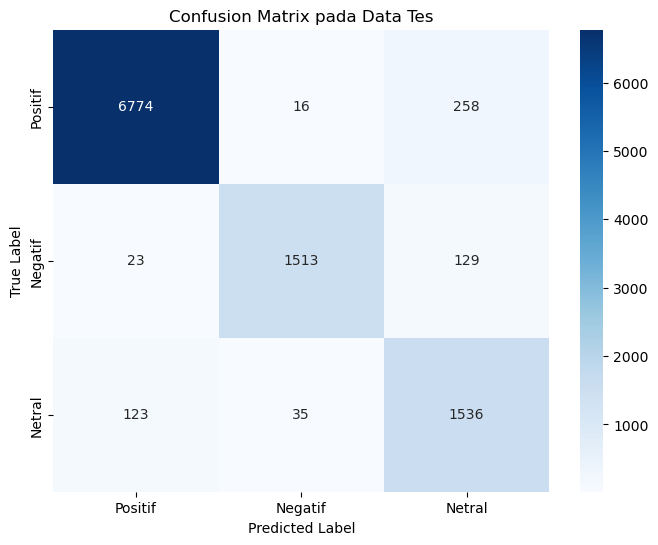

In [56]:
conf_matrix = confusion_matrix(y_test_numbered, y_pred_classes, labels=labels_ordered)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix pada Data Tes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- LANGKAH 1: Siapkan Data ---
# Di sini, Anda akan menggunakan DataFrame 'results_df' yang berisi hasil prediksi Anda.
# Saya akan membuat data contoh agar kode ini bisa berjalan.
# HAPUS BAGIAN INI jika Anda menjalankan di notebook yang sama.



# --- LANGKAH 2: Hitung Jumlah Aktual dan Prediksi per Kategori ---
actual_counts = data['Actual'].value_counts()
predicted_counts = data['Predicted'].value_counts()

# Gabungkan hasil hitungan ke dalam satu DataFrame
plot_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0).astype(int)

# BARIS FILTER DIHAPUS: Sekarang semua kelas akan ditampilkan
# plot_df = plot_df.loc[['Negatif', 'Positif']] # <-- Baris ini dihapus


# --- LANGKAH 3: Buat Plot Batang (Bar Chart) ---
sns.set_style("whitegrid")
labels = plot_df.index.tolist() # -> ['Positif', 'Negatif', 'Netral']
x = np.arange(len(labels))  # Posisi label di sumbu x
width = 0.35  # Lebar setiap batang

fig, ax = plt.subplots(figsize=(10, 7))

# Membuat batang untuk 'Predicted'
rects1 = ax.bar(x - width/2, plot_df['Predicted'], width, label='Predicted', color='skyblue')

# Membuat batang untuk 'Actual'
rects2 = ax.bar(x + width/2, plot_df['Actual'], width, label='Actual', color='salmon')

# Menambahkan label, judul, dan legenda
ax.set_ylabel('Jumlah Tweet', fontsize=12)
ax.set_xlabel('Class Sentiment', fontsize=12)
ax.set_title('Perbandingan Analisis Sentimen\nActual VS Predicted Algoritma LSTM', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Menambahkan angka di atas setiap batang
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# Merapikan layout dan menampilkan plot
fig.tight_layout()
plt.show()

KeyError: 'Actual'